In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
transform_basic = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_dataset_path = "data/train"  
test_dataset_path = "data/test"    

In [5]:
def create_data_loader(dataset_path, transform, batch_size, shuffle):
    dataset = ImageFolder(root=dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=10, pin_memory=True)
    return loader

In [6]:
def get_loaders(batch_size):
    train_loader = create_data_loader(train_dataset_path, transform_basic, batch_size, shuffle=True)
    test_loader = create_data_loader(test_dataset_path, transform_basic, batch_size, shuffle=False)
    return train_loader, test_loader

In [7]:
def save_predictions_to_folder(images, labels, predictions, output_dir, class_names=None, max_images=5):
    os.makedirs(output_dir, exist_ok=True)  
    
    images = images[:max_images].detach().cpu()  
    labels = labels[:max_images].cpu()
    predictions = predictions[:max_images].cpu()

    for idx in range(len(images)):
        image = images[idx]
        label = labels[idx].item()
        pred = predictions[idx].item()
        
        image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        image = torch.clamp(image, 0, 1)
        
        image_np = image.permute(1, 2, 0).numpy()

        title = f"Label: {label}, Pred: {pred}" if not class_names else f"Label: {class_names[label]}, Pred: {class_names[pred]}"
        
        plt.figure()
        plt.imshow(image_np)
        plt.title(title)
        plt.axis("off")
        
        filename = os.path.join(output_dir, f"image_{idx}_label_{label}_pred_{pred}.png")
        plt.savefig(filename)
        plt.close() 

In [8]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, gradient_clipping=None, output_dir="output_predictions", visualize=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_accuracy = 0
    
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        total_train_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            if gradient_clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
            
            optimizer.step()
            total_train_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                if visualize and epoch == num_epochs - 1 and i < 5:  
                    save_predictions_to_folder(images, labels, predicted, output_dir)
                
        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] Validation Accuracy: {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
    
    return best_accuracy


In [11]:
def evaluate_model(
    learning_rate=0.001, 
    batch_size=160, 
    num_epochs=5,
    optimizer_type="Adam", 
    weight_decay=0.0, 
    momentum=0.9, 
    gradient_clipping=None,
    dropout_rate=0.5,
    loss_type="cross_entropy",
    model_depth="ResNet50"
):
    if model_depth == "ResNet50":
        model = models.resnet50()
    elif model_depth == "ResNet101":
        model = models.resnet101()
    else:
        raise ValueError(f"Unsupported model depth: {model_depth}")
        
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(model.fc.in_features, 20)
    )
    
    if optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_type == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    if loss_type == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif loss_type == "kl_div":
        criterion = nn.KLDivLoss()
    elif loss_type == "mse":
        criterion = nn.MSELoss()
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")
    
    train_loader, test_loader = get_loaders(batch_size)
    

    accuracy = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, 
        num_epochs=num_epochs, gradient_clipping=gradient_clipping,
        output_dir="output_predictions", 
        visualize=True 
    )
    
    model_path = f"model_{model_depth}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    return accuracy

In [12]:
final_accuracy = evaluate_model(
    learning_rate=0.001, 
    batch_size=16, 
    num_epochs=20,
    optimizer_type="AdamW", 
    weight_decay=0.01, 
    gradient_clipping=5.0,
    dropout_rate=0.5,
    loss_type="cross_entropy",
    model_depth="ResNet50"
)
print("Final Accuracy:", final_accuracy)

Starting epoch 1/20
Epoch [1/20], Batch [0/6346], Loss: 3.6904
Epoch [1/20], Batch [100/6346], Loss: 1.9466
Epoch [1/20], Batch [200/6346], Loss: 2.4391
Epoch [1/20], Batch [300/6346], Loss: 2.0063
Epoch [1/20], Batch [400/6346], Loss: 2.5184
Epoch [1/20], Batch [500/6346], Loss: 1.5870
Epoch [1/20], Batch [600/6346], Loss: 2.3025
Epoch [1/20], Batch [700/6346], Loss: 1.1266
Epoch [1/20], Batch [800/6346], Loss: 1.3549
Epoch [1/20], Batch [900/6346], Loss: 2.1159
Epoch [1/20], Batch [1000/6346], Loss: 0.8797
Epoch [1/20], Batch [1100/6346], Loss: 1.7666
Epoch [1/20], Batch [1200/6346], Loss: 1.5906
Epoch [1/20], Batch [1300/6346], Loss: 0.7234
Epoch [1/20], Batch [1400/6346], Loss: 1.1641
Epoch [1/20], Batch [1500/6346], Loss: 1.3567
Epoch [1/20], Batch [1600/6346], Loss: 1.0925
Epoch [1/20], Batch [1700/6346], Loss: 0.7689
Epoch [1/20], Batch [1800/6346], Loss: 0.3771
Epoch [1/20], Batch [1900/6346], Loss: 0.9583
Epoch [1/20], Batch [2000/6346], Loss: 1.0607
Epoch [1/20], Batch [2100/

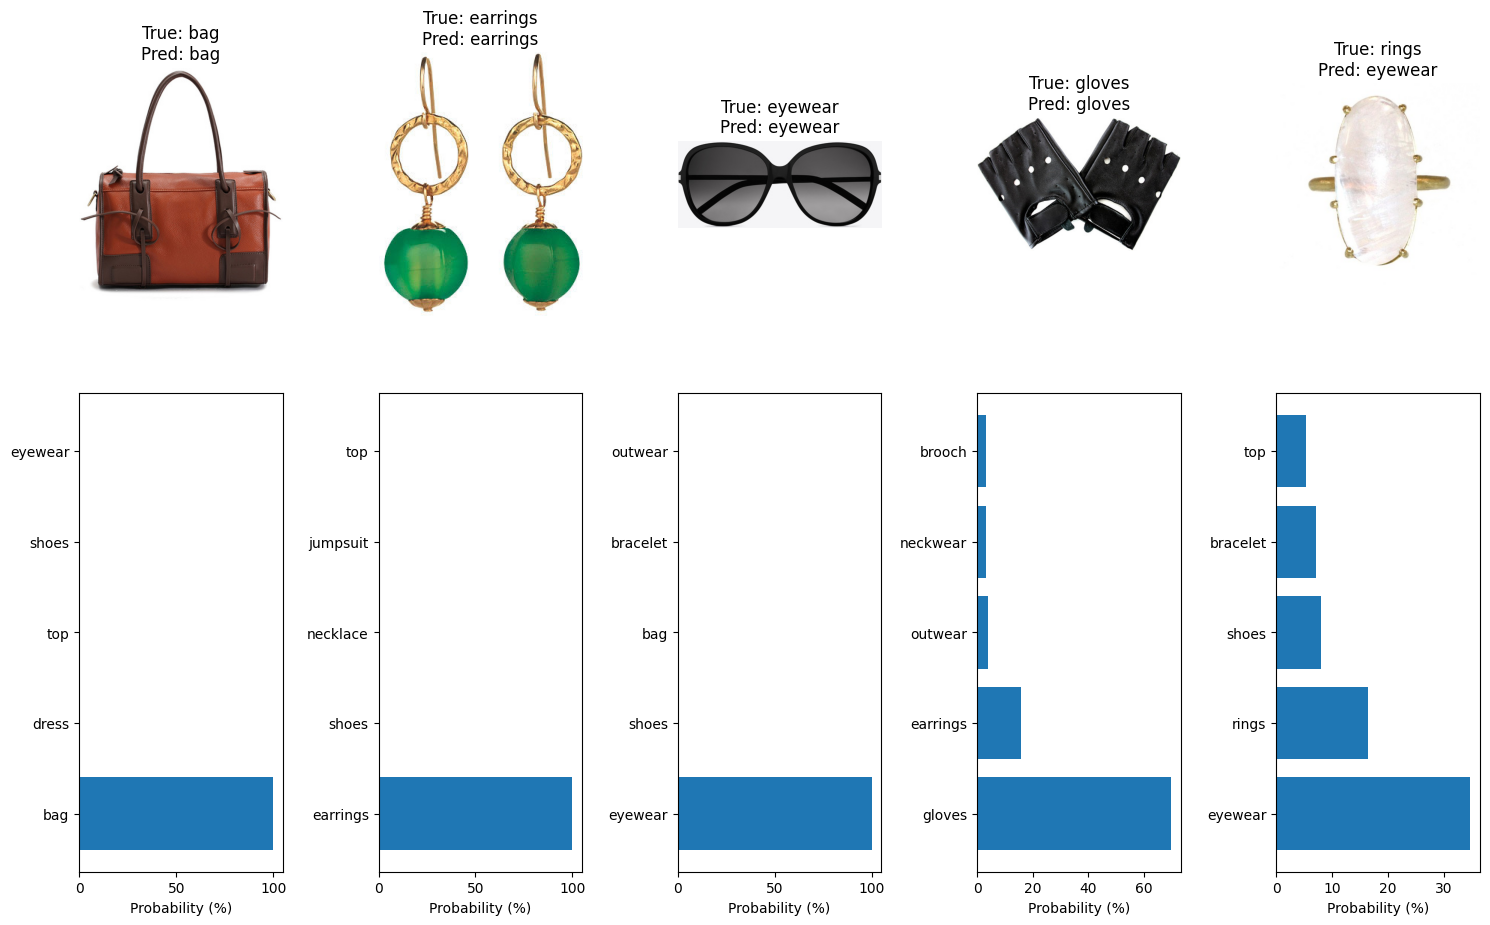

Overall Accuracy: 80.00%
Macro-Averaged F1 Score: 0.73
Weighted F1 Score: 0.73


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, models, datasets
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dir = "data/test"  
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

class_names = test_dataset.classes

model = models.resnet50(weights=None)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),  
    torch.nn.Linear(model.fc.in_features, len(class_names)) 
)
model.load_state_dict(torch.load("model_ResNet50.pth", map_location=device))
model = model.to(device)
model.eval()

image_paths = [
    "data/test/bag/102784872_4.jpg",
    "data/test/earrings/12690998_10.jpg",
    "data/test/eyewear/120631641_10.jpg",
    "data/test/gloves/67951070_6.jpg",
    "data/test/rings/78167019_5.jpg"
]

true_labels = []  
predicted_labels = []  

plt.figure(figsize=(15, 10))
for i, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert('RGB')
    input_tensor = test_transforms(image).unsqueeze(0)  # 增加batch维度
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        output = model(input_tensor)
        top5_prob, top5_idx = torch.topk(output.softmax(dim=1), 5)

    label_name = image_path.split('/')[-2] 
    label_idx = class_names.index(label_name) 
    pred_idx = top5_idx[0][0].item()  

    true_labels.append(label_idx)
    predicted_labels.append(pred_idx)

    top5_labels = [class_names[idx] for idx in top5_idx[0]]
    plt.subplot(2, 5, i + 1)
    image_np = np.array(image)
    plt.imshow(image_np)
    plt.title(f"True: {label_name}\nPred: {top5_labels[0]}")
    plt.axis('off')

    plt.subplot(2, 5, 5 + i + 1)
    plt.barh(top5_labels, (top5_prob[0].cpu().numpy() * 100).clip(0, 100))
    plt.xlabel('Probability (%)')

plt.tight_layout()
plt.show()

accuracy = accuracy_score(true_labels, predicted_labels)
f1_macro = f1_score(true_labels, predicted_labels, average='macro')
f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Macro-Averaged F1 Score: {f1_macro:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")

